<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/finetune/MT_5_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

## Code

In [2]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [3]:
# test scripts.func_utils.py

from scripts.func_utils import *
from scripts.yaml_utils import *
from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *

from tdc.utils import retrieve_label_name_list
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
label_list = retrieve_label_name_list('herg_central')


Vocab type for RNN: smiles


## Run 5 regression task, the same time saved in folder R5

In [4]:
def train_mt(name, model_type, folder_name, repeat_time, retrain, uw):
    """
    Aim: train single task or multiple task, regression or classification
    param
        name:        str or list, name(s) of task
        model_type:  str, model type
        folder_name: str, the dir of saved model and yml files
        repeat_time: int, repeat training the same model several times
        retrain:     bool,
                     if False, will check whether there exists pretrained
                     else:     retrain anyway and delete past files
        uw:          bool, use uncertainty weight between tasks or not
    Return a list, each element is a dict, contain performance and train loss
    """
    # if len(name) == 1 or isinstance(name, str): # single task
    #     # return train_st(name, model_type, folder_name, repeat_time, retrain)
    #     run_type = 'ST'
    #     run_type = 'MT'
    if isinstance(name, str): name = [name]
    if len(name) == 1: run_type = 'ST'; uw = False  # single task, no need uncertainty_weight
    elif len(name) >1: run_type = 'MT'
    make_path(folder_name, False)
    perfs = []


    config = get_config(model_type, name)
    dataloader_ready = False
    for i in range(repeat_time):
        print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
        save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
        print(' | save dir: ', save_dir, end=' | \t')
        config['model_path']  = save_dir + '.pt'
        config['config_path'] = save_dir + '.yml'
        config['uncertainty_weight'] = uw
        config['verbose_freq'] = 100
        config['patience'] = 30
        config['MAX_EPOCH'] = 1000
        if run_type == 'MT': config['lr'] = 1e-4

        nofile = False
        if retrain == False:
            try: # try open yml file, if file exists, and no need train
                with open(config['config_path'], 'r') as f:
                    data = yaml.safe_load(f)
                if data != None:
                    p = yml_report(data); print('--> pre data loaded')
                nofile = False
            except:
                print(f"cannot open {config['config_path']}, retrain")
                nofile = True # model was not trained yet, train the model
        if nofile or retrain:
            if dataloader_ready == False:
                trn, val, tst = collect_data(name)
                dict_scale = None; scale_here = False
                for n in name: # scale regression tasks
                    if names_dict[n] == True: scale_here = True; break
                trn, val, tst, dict_scale = scale(trn,val,tst, scale_here)
                config['scale_dict'] = dict_scale
                trn_l, val_l, tst_l, vocab = get_multi_loader(
                                                trn, val, tst, config)
                if vocab != None and config['vocab'] == None:
                    config['vocab'] = vocab # update config vocab info
                    print(f'RNN, update vocab using dataset | ',
                        f'vocab length updated:', len(vocab))
                dataloader_ready = True

            models = PRED(**config)
            p = models.train(trn_l, val_l, tst_l)

        # eval_perf_list(p, name, {});
        perfs.append(p)

    best_idx = eval_perf_list(perfs, name, {})
    eval_perf_list(perfs[best_idx], name)
    print('\n\n\n')
    return perfs


## Using uncertainty weight for 5 regression tasks

    no uw: data saved at R5/uw_no
    uw:    data saved at R5/uw


Run # 0 for MLP MT	 | save dir:  R5/uw_no/MLP_MT_0 | 	--> pre data loaded

Run # 1 for MLP MT	 | save dir:  R5/uw_no/MLP_MT_1 | 	--> pre data loaded

Run # 2 for MLP MT	 | save dir:  R5/uw_no/MLP_MT_2 | 	--> pre data loaded
repeated num # 3 idx 0 has the lowest loss from [0.013212514924816787, 0.013894330393264277, 0.013819680807905065]
******************** Caco2_Wang ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.405$\pm$0.016  &0.287$\pm$0.019  &0.535$\pm$0.018  &0.549$\pm$0.030  
 idx 0: &0.390            &0.277            &0.526            &0.564            

******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.684$\pm$0.006  &0.789$\pm$0.008  &0.889$\pm$0.005  &0.466$\pm$0.006  
 idx 0: &0.677            &0.797            &0.893            &0.461            

******************** HydrationFreeEnergy_FreeSolv ******************** 
	|       mae 

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


--> pre data loaded

Run # 1 for GIN MT	 | save dir:  R5/uw_no/GIN_MT_1 | 	cannot open R5/uw_no/GIN_MT_1.yml, retrain
collect data for:  ['Caco2_Wang', 'Lipophilicity_AstraZeneca', 'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51], 'Lipophilicity_AstraZeneca': [-1.5, 4.5], 'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43], 'Solubility_AqSolDB': [-13.1719, 2.1376816201], 'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--

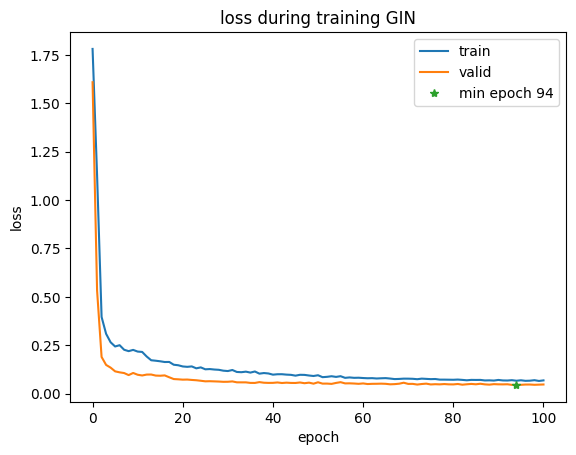

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.405  &0.256  &0.506  &0.451

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.611  &0.567  &0.753  &0.606

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.123  &2.414  &1.554  &0.795

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&1.103  &2.122  &1.457  &0.600

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.640  &0.728  &0.853  &0.239

Epoch:101 [Train] Loss: 0.065 | [Valid] Loss: 0.048	EarlyStopping counter: 7 out of 30
Epoch:102 [Train] Loss: 0.067 | [Valid] Loss: 0.048	EarlyStopping counter: 8 out of 30
Epoch:103 [Train] Loss: 0.066 | [Valid] Loss: 0.048	EarlyStopping counter: 9 out of 30
Epoch:104 [Train] Loss: 0.066 | [Valid] Loss: 0.048	EarlyStopping counter: 10 out of 30
Epoch:105 [Train] Loss: 0.067 | [Valid] Loss: 0.048	EarlyStopping counter: 11 out of 30
Epoc

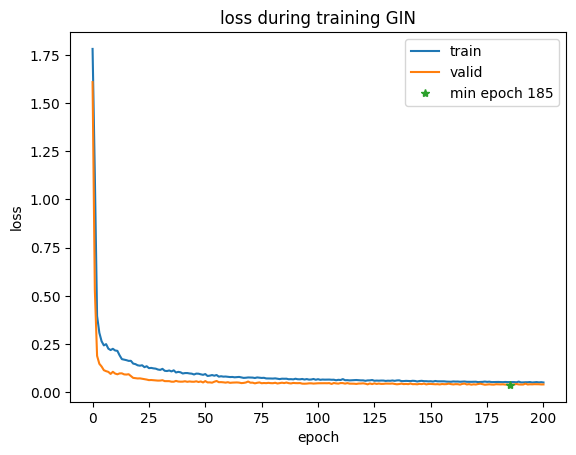

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.349  &0.201  &0.448  &0.569

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.560  &0.490  &0.700  &0.659

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.098  &2.559  &1.600  &0.783

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&1.019  &1.866  &1.366  &0.648

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.594  &0.654  &0.809  &0.316

Epoch:201 [Train] Loss: 0.051 | [Valid] Loss: 0.041	EarlyStopping counter: 16 out of 30
Epoch:202 [Train] Loss: 0.053 | [Valid] Loss: 0.043	EarlyStopping counter: 17 out of 30
Epoch:203 [Train] Loss: 0.051 | [Valid] Loss: 0.042	EarlyStopping counter: 18 out of 30
Epoch:204 [Train] Loss: 0.052 | [Valid] Loss: 0.040	EarlyStopping counter: 19 out of 30
Epoch:205 [Train] Loss: 0.051 | [Valid] Loss: 0.043	EarlyStopping counter: 20 out of 30
E

In [ ]:
names = names_reg
for model_type in model_types:
    train_mt(names, model_type, 'R5/uw_no', repeat_time=3, retrain=False, uw=False)
for model_type in model_types:
    train_mt(names, model_type, 'R5/uw',    repeat_time=3, retrain=True,  uw=True)